In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df_ens = pd.read_csv("/content/final_ensemble_results.csv")

df_ens.head()

,actual,arima,rf,lstm,ensemble_manual,ensemble_stacked
0,0.035932,-0.000768,0.001655,0.000414,0.000494,-0.000702
1,0.038176,0.004059,0.000099,0.002184,0.002017,0.001445
2,0.035512,0.004592,-0.002993,0.003187,0.001446,0.002840
3,-0.020383,0.004430,-0.002398,0.002416,0.001335,0.002451
4,-0.007752,-0.000841,0.001245,-0.002397,-0.000656,-0.001092


In [3]:
df_ens["signal"] = np.where(
    df_ens["ensemble_stacked"] > 0, 1, -1
)

In [4]:
df_ens["strategy_return"] = df_ens["signal"] * df_ens["actual"]

In [5]:
df_ens["cum_strategy"] = df_ens["strategy_return"].cumsum()
df_ens["cum_market"]  = df_ens["actual"].cumsum()

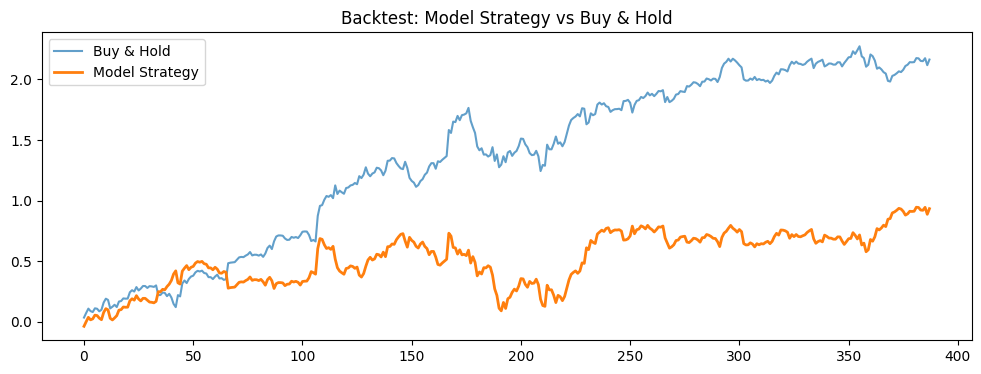

In [6]:
plt.figure(figsize=(12,4))
plt.plot(df_ens["cum_market"], label="Buy & Hold", alpha=0.7)
plt.plot(df_ens["cum_strategy"], label="Model Strategy", linewidth=2)
plt.legend()
plt.title("Backtest: Model Strategy vs Buy & Hold")
plt.show()


In [7]:
direction_acc = (
    (df_ens["signal"] == (df_ens["actual"] > 0))
).mean()

direction_acc


np.float64(0.3711340206185567)

In [8]:
sharpe = (
    df_ens["strategy_return"].mean() /
    df_ens["strategy_return"].std()
) * np.sqrt(252)

sharpe


np.float64(0.9409869391490816)

In [9]:
sharpe = (
    df_ens["strategy_return"].mean() /
    df_ens["strategy_return"].std()
) * np.sqrt(252)

sharpe


np.float64(0.9409869391490816)

In [10]:
cum = df_ens["cum_strategy"]
drawdown = cum - cum.cummax()
max_drawdown = drawdown.min()

max_drawdown


-0.6405366472734894

In [11]:
cost = 0.001

df_ens["strategy_return_tc"] = (
    df_ens["strategy_return"] - cost * df_ens["signal"].diff().abs().fillna(0)
)

df_ens["cum_strategy_tc"] = df_ens["strategy_return_tc"].cumsum()


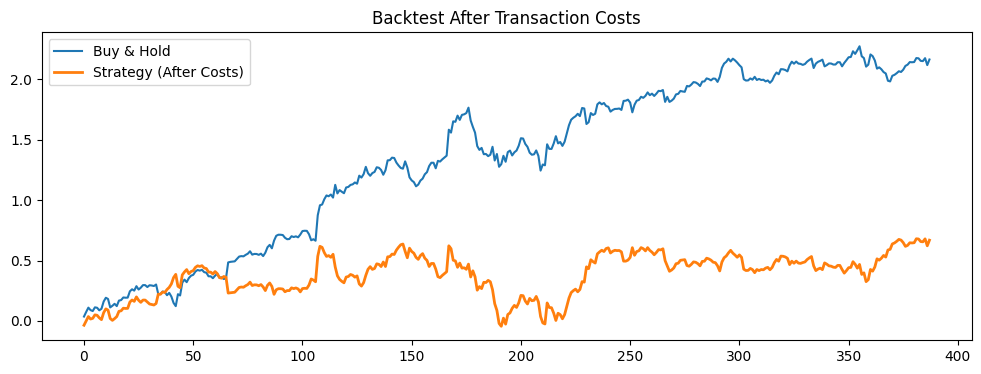

In [12]:
plt.figure(figsize=(12,4))
plt.plot(df_ens["cum_market"], label="Buy & Hold")
plt.plot(df_ens["cum_strategy_tc"], label="Strategy (After Costs)", linewidth=2)
plt.legend()
plt.title("Backtest After Transaction Costs")
plt.show()

In [13]:
threshold = df_ens["ensemble_stacked"].abs().quantile(0.75)

df_ens["signal_conf"] = np.where(
    df_ens["ensemble_stacked"] > threshold, 1,
    np.where(df_ens["ensemble_stacked"] < -threshold, -1, 0)
)

df_ens["strategy_conf"] = df_ens["signal_conf"] * df_ens["actual"]
df_ens["cum_conf"] = df_ens["strategy_conf"].cumsum()


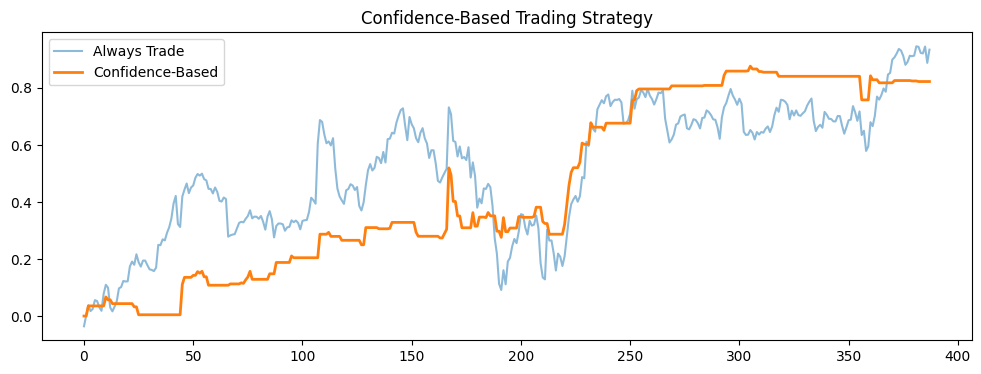

In [14]:
plt.figure(figsize=(12,4))
plt.plot(df_ens["cum_strategy"], label="Always Trade", alpha=0.5)
plt.plot(df_ens["cum_conf"], label="Confidence-Based", linewidth=2)
plt.legend()
plt.title("Confidence-Based Trading Strategy")
plt.show()

In [15]:
import yfinance as yf
import numpy as np
import pandas as pd

ticker = "PLTR"
df_new = yf.download(ticker, period="3mo", interval="1d")
df_new["log_return"] = np.log(df_new["Close"] / df_new["Close"].shift(1))
df_new.dropna(inplace=True)

/tmp/ipython-input-2123126888.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_new = yf.download(ticker, period="3mo", interval="1d")
[*********************100%***********************]  1 of 1 completed


In [16]:
ret = df_new["log_return"]

df_new["lag_1"] = ret.shift(1)
df_new["lag_2"] = ret.shift(2)
df_new["lag_5"] = ret.shift(5)

df_new["roll_mean_5"] = ret.rolling(5).mean()
df_new["roll_std_5"]  = ret.rolling(5).std()

df_new["ewma_10"] = ret.ewm(span=10).mean()
df_new["abs_return"] = ret.abs()
df_new["sq_return"]  = ret ** 2

df_new.dropna(inplace=True)


In [17]:
from statsmodels.tsa.arima.model import ARIMA

model_arima = ARIMA(ret, order=(1,0,1))
model_arima_fit = model_arima.fit()

arima_pred = model_arima_fit.forecast(1).iloc[0]

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/di

In [19]:
import joblib

rf = joblib.load("/content/rf_model.pkl")


In [20]:
rf_pred = rf.predict(latest_X)[0]

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


ValueError: X has 8 features, but RandomForestRegressor is expecting 12 features as input.

In [21]:
FEATURE_COLS = [
    "lag_1","lag_2","lag_5","lag_10",
    "roll_mean_5","roll_std_5",
    "roll_mean_20","roll_std_20",
    "ewma_10","ewma_20",
    "abs_return","sq_return"
]


In [22]:
ret = df_new["log_return"]

df_new["lag_1"] = ret.shift(1)
df_new["lag_2"] = ret.shift(2)
df_new["lag_5"] = ret.shift(5)
df_new["lag_10"] = ret.shift(10)

df_new["roll_mean_5"]  = ret.rolling(5).mean()
df_new["roll_std_5"]   = ret.rolling(5).std()
df_new["roll_mean_20"] = ret.rolling(20).mean()
df_new["roll_std_20"]  = ret.rolling(20).std()

df_new["ewma_10"] = ret.ewm(span=10).mean()
df_new["ewma_20"] = ret.ewm(span=20).mean()

df_new["abs_return"] = ret.abs()
df_new["sq_return"]  = ret ** 2

df_new.dropna(inplace=True)


In [23]:
latest_X = df_new.iloc[-1:][FEATURE_COLS]


In [24]:
rf_pred = rf.predict(latest_X)[0]
rf_pred

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


np.float64(0.00268512468104909)

In [25]:
rf_pred = rf.predict(latest_X)[0]
rf_pred

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


np.float64(0.0026851246810490905)

In [26]:
last_price = df_new["Close"].iloc[-1]
last_price

,2025-12-18
Ticker,
PLTR,185.690002


In [27]:
predicted_return = 0.0026851246810490905  # your output

predicted_price = last_price * np.exp(predicted_return)
predicted_price

,2025-12-18
Ticker,
PLTR,186.189273
